# DoWhy 

Causal Inference has four steps - 
1. **Model** a causal inference problem using assumptions.
2. **Identify** an expression for the causal effect under these assumptions (“causal estimand”).
3. **Estimate** the expression using statistical methods such as matching or instrumental variables.
4. Finally, **verify validity** of the estimate using a variety of robustness checks.

In **DoWhy** there are four verbs to capture this workflow - 
* model
* identify
* estimate
* refute

In [69]:
%matplotlib inline
import matplotlib.pyplot as plt
import dowhy
from dowhy.do_why import CausalModel
import dowhy.datasets
import numpy as np
import pandas as pd
import networkx as nx

## Step 1: Model 
* DoWhy requires graph to be specified in Graph Markup Language (GML)
* We will use `networkx` library to model our custom graph 

### LUCAS Dataset

We will use LUCAS dataset.

* LUCAS is a lung cancer toy dataset.
* LUCAS  (LUng CAncer Simple set) contains toy data generated artificially by causal Bayesian networks with binary variables. These examples are completely made up and are used for illustration purpose only. 
* LUCAS is modeling a medical application for the diagnosis, prevention, and cure of lung cancer.

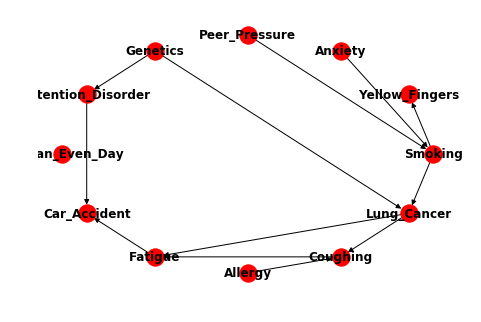

In [59]:
lucas_graph = nx.DiGraph()
lucas_graph.add_nodes_from(['Smoking', 'Yellow_Fingers', 'Anxiety', 'Peer_Pressure', 'Genetics',
       'Attention_Disorder', 'Born_an_Even_Day', 'Car_Accident', 'Fatigue',
       'Allergy', 'Coughing', 'Lung_Cancer'])
lucas_graph.add_edges_from([
    ('Anxiety', 'Smoking'), 
    ('Peer_Pressure', 'Smoking'),
    ('Smoking', 'Yellow_Fingers'), 
    ('Smoking', 'Lung_Cancer'),
    ('Genetics', 'Lung_Cancer'),
    ('Lung_Cancer', 'Fatigue'),
    ('Genetics', 'Attention_Disorder'),
    ('Allergy', 'Coughing'),
    ('Coughing', 'Fatigue'),
    ('Fatigue', 'Car_Accident'),
    ('Attention_Disorder', 'Car_Accident'),
    ('Lung_Cancer', 'Coughing')])

nx.draw_circular(lucas_graph, with_labels=True, font_weight='bold')

### Generate GML String
`dowhy` required the graph to be specified in GML.

In [99]:
lucas_graph_str = ''.join(list(nx.generate_gml(lucas_graph)))

In [100]:
lucas_graph_str

'graph [  directed 1  node [    id 0    label "Smoking"  ]  node [    id 1    label "Yellow_Fingers"  ]  node [    id 2    label "Anxiety"  ]  node [    id 3    label "Peer_Pressure"  ]  node [    id 4    label "Genetics"  ]  node [    id 5    label "Attention_Disorder"  ]  node [    id 6    label "Born_an_Even_Day"  ]  node [    id 7    label "Car_Accident"  ]  node [    id 8    label "Fatigue"  ]  node [    id 9    label "Allergy"  ]  node [    id 10    label "Coughing"  ]  node [    id 11    label "Lung_Cancer"  ]  edge [    source 0    target 1  ]  edge [    source 0    target 11  ]  edge [    source 2    target 0  ]  edge [    source 3    target 0  ]  edge [    source 4    target 11  ]  edge [    source 4    target 5  ]  edge [    source 5    target 7  ]  edge [    source 8    target 7  ]  edge [    source 9    target 10  ]  edge [    source 10    target 8  ]  edge [    source 11    target 8  ]  edge [    source 11    target 10  ]]'

### Read LUCAS data

In [63]:
df = pd.read_csv('lucas0_train.csv')
df = df.rename(columns={'Lung_cancer': 'Lung_Cancer'})
df.head()

,Smoking,Yellow_Fingers,Anxiety,Peer_Pressure,Genetics,Attention_Disorder,Born_an_Even_Day,Car_Accident,Fatigue,Allergy,Coughing,Lung_Cancer
0,0,0,1,0,0,1,0,1,0,1,0,0
1,0,1,0,0,0,0,1,0,1,0,1,1
2,1,1,1,0,1,1,1,1,1,1,1,1
3,0,0,0,1,0,0,1,0,0,0,0,0
4,1,1,1,0,0,1,1,1,1,0,0,1


### Create a `dowhy` causal model

In [64]:
lucas_model = CausalModel(
                data = df,
                treatment='Smoking',
                outcome='Lung_Cancer',
                graph=lucas_graph_str,
                )

Model to find the causal effect of treatment Smoking on outcome Lung_Cancer


/Users/tanmayee/anaconda/envs/py36/lib/python3.6/site-packages/pygraphviz/agraph.py:1341: RuntimeWarning: Warning: Could not load "/Users/tanmayee/anaconda/envs/py36/lib/graphviz/libgvplugin_pango.6.dylib" - file not found

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


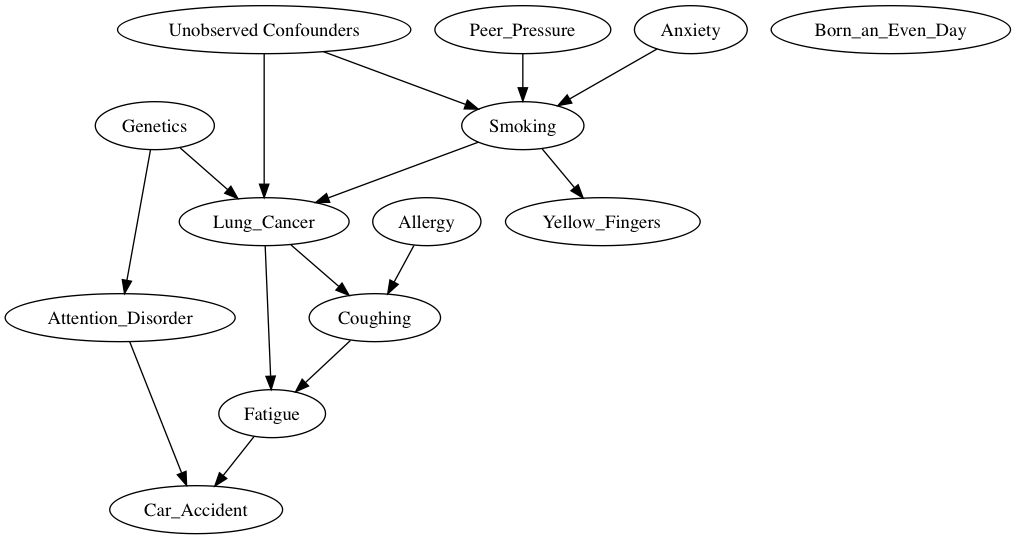

In [66]:
lucas_model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

## Step 2: Identify Estimand
Estimand is a mathematical expression and not a quantity.

In [81]:
# Identify causal effect and return target estimands
identified_estimand = lucas_model.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:{'U', 'Anxiety', 'Peer_Pressure'}


{'label': 'Unobserved Confounders', 'observed': 'no'}
There are unobserved common causes. Causal effect cannot be identified.
WARN: Do you want to continue by ignoring these unobserved confounders? [y/n] y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['Anxiety', 'Peer_Pressure']


Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                    
────────(Expectation(Lung_Cancer|Anxiety,Peer_Pressure))
dSmoking                                                
Estimand assumption 1, Unconfoundedness: If U→Smoking and U→Lung_Cancer then P(Lung_Cancer|Smoking,Anxiety,Peer_Pressure,U) = P(Lung_Cancer|Smoking,Anxiety,Peer_Pressure)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(Lung_Cancer, Anxiety)/Derivative(Smoking, Anxiety))
Estimand assumption 1, As-if-random: If U→→Lung_Cancer then ¬(U →→Anxiety,Peer_Pressure)
Estimand assumption 2, Exclusion: If we remove {Anxiety,Peer_Pressure}→Smoking, then ¬(Anxiety,Peer_Pressure→Lung_Cancer)



## Step 3: Estimate Causal Effect
In this step, we use the data to estimate the causal effect using the estimand.

### Propensity Score Matching

In [91]:
# Estimate the target estimand using a statistical method.
psm_estimate = lucas_model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_matching")
print(estimate)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: Lung_Cancer~Smoking+Anxiety+Peer_Pressure


PropensityScoreMatchingEstimator
*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                    
────────(Expectation(Lung_Cancer|Anxiety,Peer_Pressure))
dSmoking                                                
Estimand assumption 1, Unconfoundedness: If U→Smoking and U→Lung_Cancer then P(Lung_Cancer|Smoking,Anxiety,Peer_Pressure,U) = P(Lung_Cancer|Smoking,Anxiety,Peer_Pressure)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(Lung_Cancer, Anxiety)/Derivative(Smoking, Anxiety))
Estimand assumption 1, As-if-random: If U→→Lung_Cancer then ¬(U →→Anxiety,Peer_Pressure)
Estimand assumption 2, Exclusion: If we remove {Anxiety,Peer_Pressure}→Smoking, then ¬(Anxiety,Peer_Pressure→Lung_Cancer)

## Realized estimand
b: Lung_Cancer~Smoking+Anxiety+Peer_Pressure
## Estimate
Value: 0.5171972026806853

## Statistical Significance
p-value: 0.0



### Regression

In [92]:
regression_estimate = lucas_model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression",
        test_significance=True)
print(estimate)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Lung_Cancer~Smoking+Anxiety+Peer_Pressure


LinearRegressionEstimator
*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                    
────────(Expectation(Lung_Cancer|Anxiety,Peer_Pressure))
dSmoking                                                
Estimand assumption 1, Unconfoundedness: If U→Smoking and U→Lung_Cancer then P(Lung_Cancer|Smoking,Anxiety,Peer_Pressure,U) = P(Lung_Cancer|Smoking,Anxiety,Peer_Pressure)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(Lung_Cancer, Anxiety)/Derivative(Smoking, Anxiety))
Estimand assumption 1, As-if-random: If U→→Lung_Cancer then ¬(U →→Anxiety,Peer_Pressure)
Estimand assumption 2, Exclusion: If we remove {Anxiety,Peer_Pressure}→Smoking, then ¬(Anxiety,Peer_Pressure→Lung_Cancer)

## Realized estimand
b: Lung_Cancer~Smoking+Anxiety+Peer_Pressure
## Estimate
Value: 0.5171972026806853

## Statistical Significance
p-value: 0.0



## Step 4: Verify, Validate and Refute

### Propensity Score Matching

In [93]:
# Refute the obtained estimate using multiple robustness checks.
refute_results = lucas_model.refute_estimate(identified_estimand, psm_estimate,
        method_name="random_common_cause")
print(refute_results)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: Lung_Cancer~Smoking+Anxiety+Peer_Pressure+w_random


Refute: Add a Random Common Cause
Estimated effect:(0.7083056478405315,)
New effect:(0.48438538205980064,)



In [95]:
# Refute the obtained estimate using multiple robustness checks.
refute_results = lucas_model.refute_estimate(identified_estimand, psm_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(refute_results)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: Lung_Cancer~placebo+Anxiety+Peer_Pressure


Refute: Use a Placebo Treatment
Estimated effect:(0.7083056478405315,)
New effect:(-0.28637873754152826,)



In [96]:
# Refute the obtained estimate using multiple robustness checks.
refute_results = lucas_model.refute_estimate(identified_estimand, psm_estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)
print(refute_results)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: Lung_Cancer~Smoking+Anxiety+Peer_Pressure


Refute: Use a subset of data
Estimated effect:(0.7083056478405315,)
New effect:(0.11176905995558846,)



### Regression

In [94]:
# Refute the obtained estimate using multiple robustness checks.
refute_results = lucas_model.refute_estimate(identified_estimand, regression_estimate,
        method_name="random_common_cause")
print(refute_results)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Lung_Cancer~Smoking+Anxiety+Peer_Pressure+w_random


Refute: Add a Random Common Cause
Estimated effect:(0.51719720268068525,)
New effect:(0.5176203136951314,)



In [98]:
# Refute the obtained estimate using multiple robustness checks.
refute_results = lucas_model.refute_estimate(identified_estimand, regression_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(refute_results)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Lung_Cancer~placebo+Anxiety+Peer_Pressure


Refute: Use a Placebo Treatment
Estimated effect:(0.51719720268068525,)
New effect:(-0.0079064004089576204,)



In [97]:
# Refute the obtained estimate using multiple robustness checks.
refute_results = lucas_model.refute_estimate(identified_estimand, regression_estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)
print(refute_results)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Lung_Cancer~Smoking+Anxiety+Peer_Pressure


Refute: Use a subset of data
Estimated effect:(0.51719720268068525,)
New effect:(0.50391396148705869,)

